# Likert-Based Analysis of Publication Relevance for the RADx-rad Program

This notebook analyzes the relevance of scientific publications to the objectives of the [RADx-rad program](https://www.radxrad.org/) by leveraging aggregated Likert scale assessments from multiple Large Language Models (LLMs). It further validates the reliability of these assessments through a structured validation approach.

## Workflow

1. **Data Integration**
   - Import and consolidate Likert scores and scoring rationales generated by LLMs from the previous analysis step ([classification notebook](../notebooks/2_classify_publications_likert.ipynb)).

2. **Publication Relevance Analysis**
   - Analyze and visualize the distribution of mean Likert scores across evaluated publications.
   - Define a threshold to differentiate clearly between relevant and non-relevant publications based on the analyzed distributions.

3. **Validation of Likert Scoring Method**
   - Create a validation dataset using explicit mentions of "RADx" and associated grant numbers as ground truth.
   - Calculate and interpret binary classification metrics (precision, recall, accuracy, F1-score) to evaluate and demonstrate the robustness of the scoring methodology.

**Author:** Peter W. Rose ([pwrose@ucsd.edu](mailto:pwrose@ucsd.edu))  
**Date:** 2025-03-13

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import scipy.stats as stats

pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
ANNOTATION = "annotation_full_text_5" # The full text of the FOA was used to evaluate the relevance of publications to the RADx-rad program
LAST_UPDATE = "2025-06-17" # Date publications were last retrieved from PubMed

In [3]:
RADX_RAD_MENTION = "../derived_data/publications_radx_mentions.csv" # papers mentioning "RADx"

## 1. Data Integration: Likert Scores and Rationales
Import and consolidate Likert scores and scoring rationales generated by LLMs from the previous analysis step

In [4]:
# Place the models in order from least selective to most selective
models = ["Llama-3.3-70B-Instruct", "DeepSeek-R1-Distill-Qwen-32B"]

In [5]:
files = glob.glob(f"../results/*/{ANNOTATION}/*.csv")
# Filter files to include only those containing one of the models in their path
files = [file for file in files if any(model in file for model in models)]
df = pd.concat([pd.read_csv(f, keep_default_na=False, dtype=str) for f in files], ignore_index=True)

df["result"] = df["result"].astype(int)
# Create a composite key (note, the pm_id is missing for a few entries?)
df["identifier"] = df["pm_id"] + "_" + df["dbgap_accession"]

In [6]:
df[df["identifier"].str.startswith("_")]

,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,year,article_type,...,url,summary,result,explanation,model,prompt_tokens,completion_tokens,elapsed_time,cost,identifier
562,,,doi:10.1021/acs.jpcc.2c06434,Understanding Oligonucleotide Hybridization an...,"""Semiconducting single-walled carbon nanotubes...",|Carbon nanotubes|Genetics|Hybridization|Quant...,Cui J|Gong X|Cho S-Y|Jin X|Yang S|Khosravi-Far...,J Phys Chem C,2023,Journal Article,...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,4,The publication abstract discusses the develop...,DeepSeek-R1-Distill-Qwen-32B,16978,133,2.8,0.0,_phs002570.v1.p1
1314,,,doi:10.1021/acs.jpcc.2c06434,Understanding Oligonucleotide Hybridization an...,"""Semiconducting single-walled carbon nanotubes...",|Carbon nanotubes|Genetics|Hybridization|Quant...,Cui J|Gong X|Cho S-Y|Jin X|Yang S|Khosravi-Far...,J Phys Chem C,2023,Journal Article,...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,4,The publication abstract is related to the res...,Llama-3.3-70B-Instruct,16557,189,14.9,0.0,_phs002570.v1.p1


In [7]:
df.head(100)

,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,year,article_type,...,url,summary,result,explanation,model,prompt_tokens,completion_tokens,elapsed_time,cost,identifier
0,35599981,PMC9111030,doi:10.1002/pul2.12071,Pulmonary endothelial NEDD9 and the prothrombo...,The pathobiology of in situ pulmonary thrombos...,SARS‐CoV‐2|acute respiratory distress syndrome...,"Alba, George A|Samokhin, Andriy O|Wang, Rui-Sh...",Pulmonary circulation,2022,Journal Article,...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,1,The publication abstract focuses on the pathob...,DeepSeek-R1-Distill-Qwen-32B,17465,250,5.1,0.0,35599981_phs002602.v1.p1
1,34270923,PMC8936511,doi:10.1016/S2213-2600(21)00072-2,Mildly elevated pulmonary artery systolic pres...,Pulmonary hypertension is associated with incr...,Blood Pressure|Echocardiography|Echocardiograp...,"Jankowich, Matthew|Maron, Bradley A|Choudhary,...",The Lancet. Respiratory medicine,2021,"Journal Article|Research Support, N.I.H., Extr...",...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,1,The publication abstract discusses pulmonary h...,DeepSeek-R1-Distill-Qwen-32B,16895,76,1.8,0.0,34270923_phs002602.v1.p1
2,29431424,PMC5994911,doi:10.1021/acschemneuro.8b00044,Gadolinium-Free Contrast Agents for Magnetic R...,We discuss how the recent revelation that gado...,Central Nervous System|Contrast Media|GBCA|Gad...,"Gale, Eric M|Caravan, Peter",ACS chemical neuroscience,2018,"Journal Article|Research Support, N.I.H., Extr...",...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,1,The publication abstract discusses the develop...,DeepSeek-R1-Distill-Qwen-32B,16692,127,2.7,0.0,29431424_phs002602.v1.p1
3,36565787,,doi:10.1016/j.ahj.2022.12.009,Pursuing functional biomarkers in complex dise...,"A major gap in diagnosis, classification, risk...",Artificial intelligence|Biomarkers|Humans|Mach...,"Benincasa, Giuditta|Napoli, Claudio|Loscalzo, ...",American heart journal,2023,"Journal Article|Research Support, N.I.H., Extr...",...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,1,The publication abstract focuses on pulmonary ...,DeepSeek-R1-Distill-Qwen-32B,16989,108,2.3,0.0,36565787_phs002561.v1.p1
4,35759871,PMC11926770,doi:10.1146/annurev-micro-041020-111511,Harnessing the Immune Response to Fungal Patho...,Invasive fungal infections are emerging diseas...,Animals|Fungal Vaccines|Humans|Immunity|Invasi...,"Rivera, Amariliz|Lodge, Jennifer|Xue, Chaoyang",Annual review of microbiology,2022,"Journal Article|Research Support, N.I.H., Extr...",...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,1,The publication abstract focuses on fungal vac...,DeepSeek-R1-Distill-Qwen-32B,16881,66,1.5,0.0,35759871_phs002583.v1.p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,39243301,PMC11807383,doi:10.1007/s00216-024-05518-z,Extraction of redox extracellular vesicles usi...,Studying specific subpopulations of cancer-der...,"4-Hydroxynonenal (HNE)|Aldehydes|Cell Line, Tu...","Banadaki, Mohammad Dehghan|Rummel, Nicole G|Ba...",Analytical and bioanalytical chemistry,2024,Journal Article,...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational Institutes of Health (NIH)/n...,2,The publication abstract focuses on the extrac...,DeepSeek-R1-Distill-Qwen-32B,12167,99,2.1,0.0,39243301_phs002542.v1.p1
96,38557701,,doi:10.1097/MAT.0000000000002209,Anatomical and Hemodynamic Characterization of...,We characterize the anatomy and function of ne...,"Heart, Artificial|Hemodynamics|Humans","Monreal, Gretel|Koenig, Steven C|Huang, Jiapen...",ASAIO journal (American Society for Artificial...,2024,"Journal Article|Research Support, N.I.H., Extr...",...,https://grants.nih.gov/grants/guide/rfa-files/...,EXPIRED/nNational In

In [8]:
# Identify the columns that define the "group" or pivot index
group_cols = [
    "identifier", "pm_id", "pmc_id", "doi", "title", "abstract", "keywords", "authors", "journal", 
    "article_type", "year", "award_type", "supplement", "project_serial_num",
    "sub_project", "project_num", "dbgap_accession", "research_initiative",
    "dbgap_title", "focus", "dbgap_abstract", "id", "name", "url", "summary"
]

# Identify the columns to pivot (the ones to transform into wide format)
value_cols = [
    "result", "explanation", "prompt_tokens", 
    "completion_tokens", "elapsed_time", "cost"
]

# Pivot the DataFrame so that each model creates new columns for the value columns above
grouped_df = df.pivot_table(
    index=group_cols,            # these become the index
    columns="model",             # these become the pivoted columns
    values=value_cols,           # these are the values to fill
    aggfunc="first"              # how to aggregate if multiple rows exist
)

# Rename the multi-level columns so that each becomes e.g. "result_gpt-4o"
grouped_df.columns = [
    f"{val_col}_{model}" for val_col, model in grouped_df.columns
]

grouped_df.columns = grouped_df.columns.str.removeprefix("result_")

# Reset the index to make it a regular column
grouped_df = grouped_df.reset_index()

In [9]:
print("Number of publication-Study Pairs:", grouped_df.shape[0])
grouped_df.head()

Number of publication-Study Pairs: 752


,identifier,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,article_type,...,cost_DeepSeek-R1-Distill-Qwen-32B,cost_Llama-3.3-70B-Instruct,elapsed_time_DeepSeek-R1-Distill-Qwen-32B,elapsed_time_Llama-3.3-70B-Instruct,explanation_DeepSeek-R1-Distill-Qwen-32B,explanation_Llama-3.3-70B-Instruct,prompt_tokens_DeepSeek-R1-Distill-Qwen-32B,prompt_tokens_Llama-3.3-70B-Instruct,DeepSeek-R1-Distill-Qwen-32B,Llama-3.3-70B-Instruct
0,26149051_phs002561.v1.p1,26149051,PMC5565795,doi:10.1111/jth.12942,Road blocks in making platelets for transfusion.,The production of laboratory-generated human p...,Bioreactors|Blood Platelets|Cell Culture Techn...,"Thon, J N|Medvetz, D A|Karlsson, S M|Italiano,...",Journal of thrombosis and haemostasis : JTH,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,0.0,1.9,12.4,The publication abstract discusses challenges ...,The publication abstract is unrelated to the r...,16823,16405,1,1
1,26149051_phs002602.v1.p1,26149051,PMC5565795,doi:10.1111/jth.12942,Road blocks in making platelets for transfusion.,The production of laboratory-generated human p...,Bioreactors|Blood Platelets|Cell Culture Techn...,"Thon, J N|Medvetz, D A|Karlsson, S M|Italiano,...",Journal of thrombosis and haemostasis : JTH,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,0.0,1.5,9.9,The publication abstract discusses challenges ...,The publication abstract is unrelated to the r...,16692,16279,1,1
2,26506125_phs002561.v1.p1,26506125,PMC4674364,doi:10.1016/j.bbadis.2015.10.019,S-adenosylhomocysteine induces inflammation th...,S-adenosylhomocysteine (SAH) can induce endoth...,Adhesion molecules|Cell Line|EZH2|Endothelial ...,"Barroso, Madalena|Kao, Derrick|Blom, Henk J|Ta...",Biochimica et biophysica acta,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,0.0,3.1,13.6,The publication abstract discusses the role of...,The publication abstract is not related to the...,17095,16676,1,1
3,26506125_phs002602.v1.p1,26506125,PMC4674364,doi:10.1016/j.bbadis.2015.10.019,S-adenosylhomocysteine induces inflammation th...,S-adenosylhomocysteine (SAH) can induce endoth...,Adhesion molecules|Cell Line|EZH2|Endothelial ...,"Barroso, Madalena|Kao, Derrick|Blom, Henk J|Ta...",Biochimica et biophysica acta,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,0.0,2.8,10.9,The publication abstract discusses the role of...,The publication abstract is unrelated to the r...,16964,16550,1,1
4,26968099_phs002561.v1.p1,26968099,PMC5375104,doi:10.1016/j.bbalip.2016.03.007,miRNA regulation of LDL-cholesterol metabolism.,"In the past decade, microRNAs (miRNAs) have em...","Animals|Cardiovascular Diseases|Cholesterol, L...","Goedeke, Leigh|Wagschal, Alexandre|Fernández-H...",Biochimica et biophysica acta,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,0.0,1.8,11.5,The publication abstract discusses miRNA regul...,The publication abstract is unrelated to the r...,16994,16576,1,1


In [10]:
# Remove false assignments due to two studies funded by the same grant.
# In those cases, publications must only be mapped to the corresponding study and not both.
grouped_df = grouped_df[grouped_df["identifier"] != "37851606_phs002561.v1.p1"]

In [11]:
# Sum up the likert_score
grouped_df["likert_score"] = grouped_df[models].sum(axis=1)/len(models)

In [12]:
# Publications with inconsistent ratings
grouped_df[abs(grouped_df['DeepSeek-R1-Distill-Qwen-32B'] - grouped_df['Llama-3.3-70B-Instruct']) >= 2]

,identifier,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,article_type,...,cost_Llama-3.3-70B-Instruct,elapsed_time_DeepSeek-R1-Distill-Qwen-32B,elapsed_time_Llama-3.3-70B-Instruct,explanation_DeepSeek-R1-Distill-Qwen-32B,explanation_Llama-3.3-70B-Instruct,prompt_tokens_DeepSeek-R1-Distill-Qwen-32B,prompt_tokens_Llama-3.3-70B-Instruct,DeepSeek-R1-Distill-Qwen-32B,Llama-3.3-70B-Instruct,likert_score
99,32511591_phs002527.v1.p1,32511591,PMC7276018,doi:10.1101/2020.04.17.20069641,An 81 base-pair deletion in SARS-CoV-2 ORF7a i...,,,"Holland, LaRinda A|Kaelin, Emily A|Maqsood, Ra...",medRxiv : the preprint server for health sciences,Journal Article|Preprint,...,0.0,2.5,15.8,The publication abstract describes the identif...,The publication abstract is directly related t...,12016,11758,2,5,3.500
120,32864699_phs002585.v1.p1,32864699,PMC7529060,doi:10.1093/ajcp/aqaa157,Clinical Validation and Performance Evaluation...,Evaluation of serostatus against severe acute ...,"Antibodies, Viral|Betacoronavirus|COVID-19|COV...","Garnett, Emily|Jung, Joanna|Tam, Estella|Rajap...",American journal of clinical pathology,Journal Article|Validation Study,...,0.0,2.4,17.5,The publication abstract describes the validat...,The publication abstract is related to the res...,14913,14540,2,4,3.000
136,33290544_phs002603.v1.p1,33290544,PMC7724906,doi:10.1182/bloodadvances.2020003471,Evidence of thrombotic microangiopathy in chil...,Most children with severe acute respiratory sy...,"Acute Kidney Injury|Adolescent|Antibodies, Vir...","Diorio, Caroline|McNerney, Kevin O|Lambert, Mi...",Blood advances,"Journal Article|Research Support, N.I.H., Extr...",...,0.0,2.9,13.1,The publication abstract discusses the presenc...,The publication abstract directly addresses th...,14969,14566,3,5,4.000
156,33640145_phs002585.v1.p1,33640145,PMC7904456,doi:10.1016/j.vaccine.2021.01.054,Multisystem inflammatory syndrome in children ...,This is a Brighton Collaboration Case Definiti...,Adult|Adults|Adverse event|COVID-19|COVID-19 V...,"Vogel, Tiphanie P|Top, Karina A|Karatzios, Chr...",Vaccine,"Journal Article|Research Support, Non-U.S. Gov...",...,0.0,3.8,18.8,The publication abstract describes the develop...,The publication abstract directly addresses th...,14703,14343,3,5,4.000
160,33754452_phs002585.v1.p1,33754452,PMC8250508,doi:10.1111/ajt.16572,Multisystem inflammatory syndrome in children ...,We present the case of a 3-year-old female liv...,"COVID-19|Child|Child, Preschool|Female|Humans|...","Petters, Leanne M|Vogel, Tiphanie P|Munoz, Flo...",American journal of transplantation : official...,Case Reports|Journal Article,...,0.0,3.0,16.1,The publication abstract describes a case of M...,The publication abstract directly addresses th...,14693,14330,3,5,4.000
165,33819338_phs002603.v1.p1,33819338,PMC8202764,doi:10.1097/ALN.0000000000003765,Concordance of Upper and Lower Respiratory Tra...,,Adolescent|Bronchi|COVID-19|COVID-19 Nucleic A...,"Lin, Elaina E|Akaho, Elikplim H|Sobilo, Anna|B...",Anesthesiology,"Letter|Research Support, N.I.H., Extramural|Re...",...,0.0,2.5,15.5,The publication abstract discusses the concord...,The publication abstract is related to the res...,14517,14153,2,4,3.000
181,33949910_phs002585.v1.p1,33949910,,doi:10.1080/08880018.2021.1917737,Immune thrombocytopenia following multisystem ...,Patients with coronavirus disease 2019 (COVID-...,"Anti-Inflammatory Agents, Non-Steroidal|Aspiri...","Kok, Eric Y|Srivaths, Lakshmi|Grimes, Amanda B...",Pediatric hematology and oncology,Case Reports|Journal Article,...,0.0,3.0,15.1,The publication abstract describes a case seri...,The publication abstract is related to the res...,14703,14339,2,4,3.000
202,34260489_phs002553.v1.p1,34260489,PMC8373777,doi:10.1097/INF.0000000000003219,Hyponatremia in Patients With Multisystem Infl...,We report 2 patients with multisystem inflamma...,"Antibodies, Viral|COVID-19|Child|Female|Fluid ...","Mills, Tatyana|Trivedi, Aditi|Tremoulet, Adria...",The Pediatric infecti

## 2. Publication Relevance Analysis

### Analyze and visualize the distribution of mean Likert scores across evaluated publications


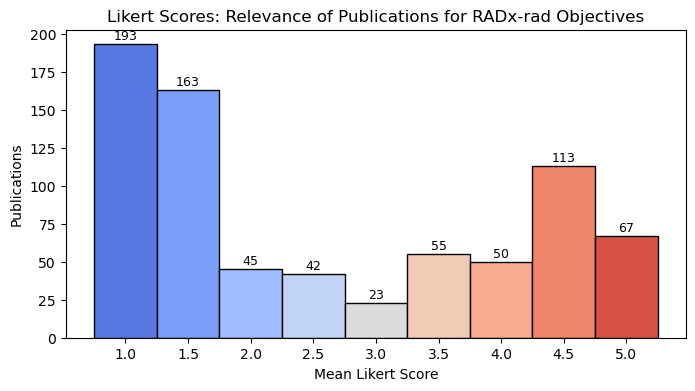

In [13]:
# Create a gradient palette (blue → red)
gradient_palette = sns.color_palette("coolwarm", n_colors=9)
# Define bin edges with 0.5 increments
bins = np.arange(1, 6, 0.5)

# Plot the histogram
ax = grouped_df["likert_score"].plot(
    kind="hist",
    bins=bins,
    edgecolor="black",
    align="left",
    figsize=(8, 4),
)

# Loop through each bar (patch) in the histogram
for i, patch in enumerate(ax.patches):
    x_left = patch.get_x()
    width = patch.get_width()
    height = patch.get_height()

    # Compute the center x-position of the bar
    x_center = x_left + width / 2

    # # Map the x-position to the gradient palette
    patch.set_facecolor(gradient_palette[i])

    # Add text labels above each bar
    y_top = height + 1
    label_text = f"{int(height)}"
    ax.text(
        x_center,
        y_top,
        label_text,
        ha="center",  # horizontal alignment: center
        va="bottom",  # vertical alignment: the "bottom" of text is on y_top
        fontsize=9
    )

# Set labels and title
ax.set_xlabel("Mean Likert Score")
ax.set_ylabel("Publications")
ax.set_title("Likert Scores: Relevance of Publications for RADx-rad Objectives")

# Set the tick spacing to 0.5
ax.xaxis.set_major_locator(MultipleLocator(0.5))

plt.show()

The histogram shows a bimodal distribution of mean Likert scores. Publications highlighted in red indicate those deemed relevant to the RADx-rad program (mean Likert score ≥ 3.5). The threshold score of 3.5 was chosen as it represents the midpoint between the Likert scale responses: **"3: Neither agree nor disagree"** and **"4: Agree."**

In [14]:
THRESHOLD = 3.5

## Histogram of the Likert Scores by LLM

In [15]:
sort_order = list(reversed(models))
grouped_df = grouped_df.sort_values(by=["likert_score"] + sort_order)
print("Number of publication-study pairs with Likert score:", grouped_df.shape[0])

Number of publication-study pairs with Likert score: 751


In [16]:
# Normalize Likert scales for all models
expanded_norm = grouped_df[models] / len(models)

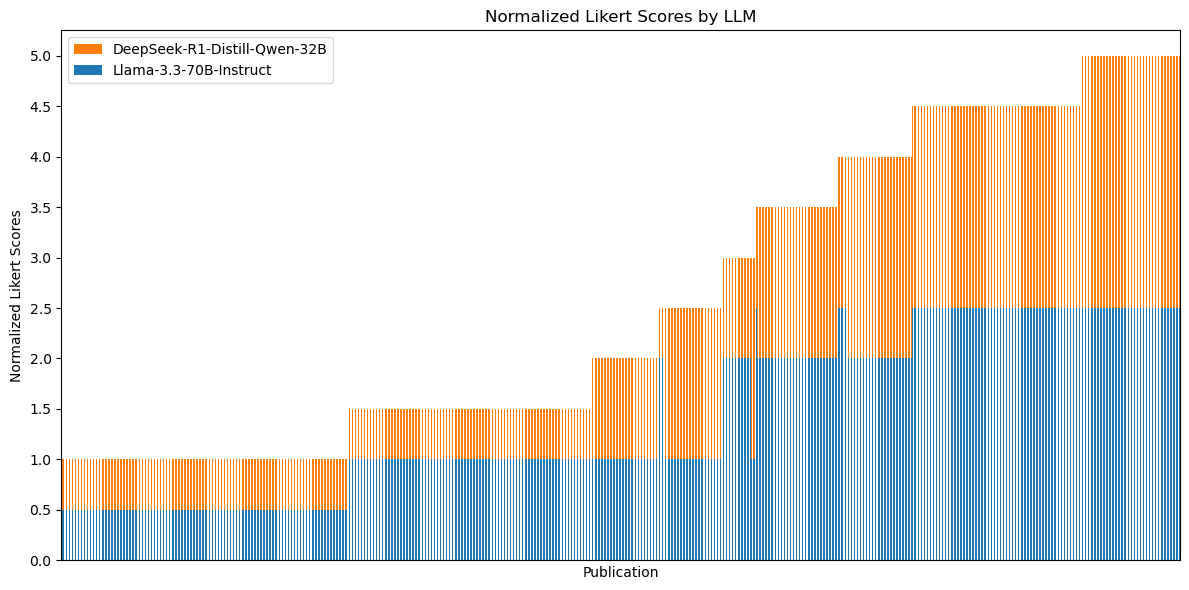

In [17]:
# Create a stacked bar chart
ax = expanded_norm.plot(kind="bar", stacked=True, figsize=(12,6))
#ax = grouped_df.plot(kind="bar", stacked=True, figsize=(30,15))

# Set labels and title
ax.set_xlabel("Publication")
ax.set_xticks([])
ax.set_ylabel("Normalized Likert Scores")
ax.set_title("Normalized Likert Scores by LLM")

# Reverse the legend entries
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Set the tick spacing to 0.5
ax.yaxis.set_major_locator(MultipleLocator(0.5))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Each vertical bar represents a unique publication-study pair. A single publication may be evaluated across multiple studies. Both LLMs exhibit similar scoring patterns, however, the **Llama-3.3-70B-Instruct** model tends to assign higher Likert scores overall, indicating a less selective assessment compared to the **DeepSeek-R1-Destill-Qwen-32B** model.

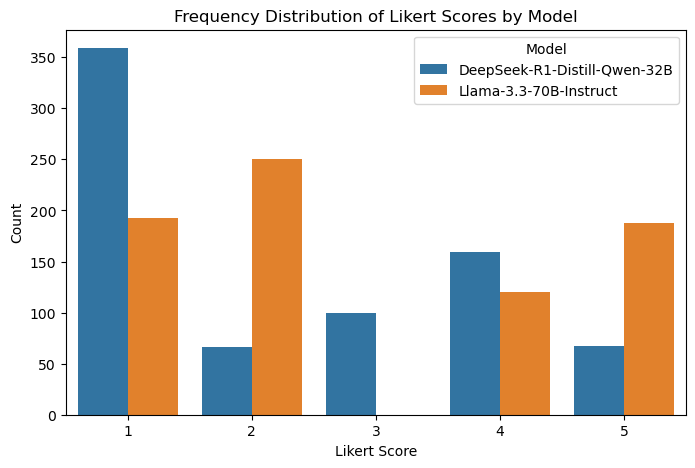

In [18]:
# Reshape the data to long format for easier comparison
df_long = grouped_df[["DeepSeek-R1-Distill-Qwen-32B", "Llama-3.3-70B-Instruct"]].melt(
    var_name="Model", value_name="Likert_Score"
)

plt.figure(figsize=(8, 5))
sns.countplot(data=df_long, x="Likert_Score", hue="Model")
plt.title("Frequency Distribution of Likert Scores by Model")
plt.xlabel("Likert Score")
plt.ylabel("Count")
plt.show()

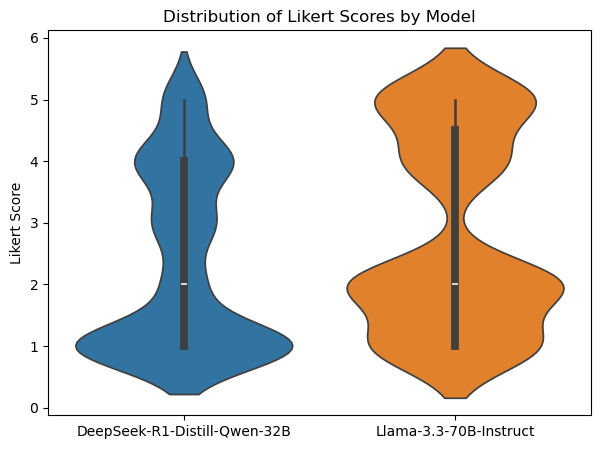

In [19]:
# Violin Plot
plt.figure(figsize=(7,5))
sns.violinplot(data=grouped_df[["DeepSeek-R1-Distill-Qwen-32B", "Llama-3.3-70B-Instruct"]], 
               density_norm="area", 
               common_norm=False)
plt.title("Distribution of Likert Scores by Model")
plt.ylabel("Likert Score")
plt.show()

### Distribution of Publications by Likert Scores per Year

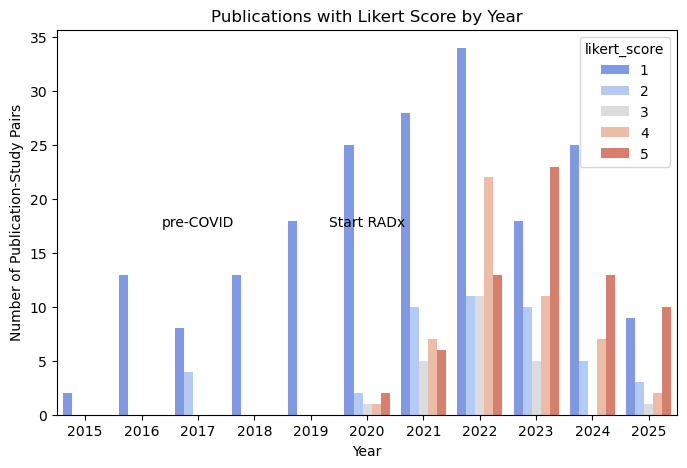

In [20]:
# Create a gradient palette for likert_score (blue→red)
gradient_palette = sns.color_palette("coolwarm", n_colors=5)

plt.figure(figsize=(8, 5))

# Create the grouped bar chart by year and likert_score
ax = sns.countplot(
    data=grouped_df,
    x="year",
    hue="likert_score",
    palette=gradient_palette,
    hue_order=range(1, 6)
)

plt.xlabel("Year")
plt.ylabel("Number of Publication-Study Pairs")
plt.title("Publications with Likert Score by Year")

# Get the numeric positions (ticks) and the associated text labels (the actual years)
xticks = ax.get_xticks()
xlabels = [label.get_text() for label in ax.get_xticklabels()]

# Determine the halfway point of the *overall* y-axis range
y_min, y_max = ax.get_ylim()
y_mid = (y_max - y_min) / 2

# Loop over each tick position and its label
for x_pos, x_label in zip(xticks, xlabels):
    # Convert to integer if needed
    year_val = int(x_label)
    
    # If it"s 2017, place "pre-COVID"
    if year_val == 2017:
        ax.text(
            x_pos,
            y_mid,           # halfway up the entire chart
            "pre-COVID",
            ha="center",
            va="center",
            color="black",
        )
    # If it"s 2020, place "Start RADx"
    elif year_val == 2020:
        ax.text(
            x_pos,
            y_mid,           # halfway up the entire chart
            "Start RADx",
            ha="center",
            va="center",
            color="black",
        )

plt.show()

Publications released before the initiation of the RADx-rad program predominantly receive Likert scores of **"1: Strongly disagree"** and **"2: Disagree"**, clearly indicating their irrelevance to the current RADx-rad objectives.

In [21]:
def plot_counts(df, group_by, label):
    # Sort categories alphabetically
    order = sorted(df[group_by].unique())

    # Create a list of colors using the "coolwarm" colormap
    gradient_palette = sns.color_palette("coolwarm", n_colors=5)
    
    # Create the figure with the desired size
    #plt.figure(figsize=(8, 5))
    plt.figure(figsize=(14, 5))
    
    sns.countplot(
        data=df, 
        x=group_by, 
        hue="likert_score", 
        order=order, 
        palette=gradient_palette,
        hue_order=range(1, 6)
    )

    # Rotate x-axis labels
    plt.xticks(rotation=90)
    
    plt.xlabel(label)
    plt.ylabel("Number of Publication-Study Pairs")
    plt.title(f"Likert Scores per {label}")
    plt.show()

### Relevant Publication-Study Pairs by Study (dbGaP Accession Number)

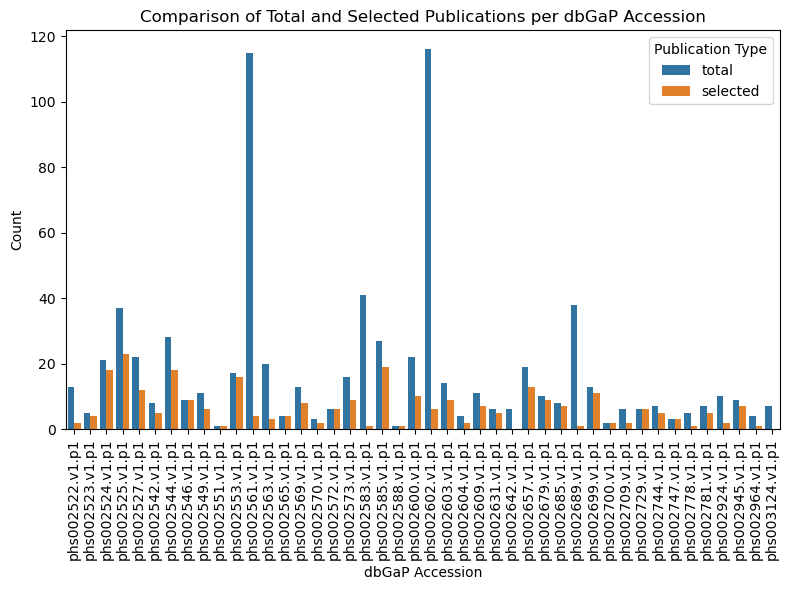

In [22]:
grouped_df["selected"] = grouped_df["likert_score"] >= THRESHOLD

# Group by 'dbgap_accession' and aggregate
result_df = grouped_df.groupby('dbgap_accession').agg(
    total=('dbgap_accession', 'size'),
    selected=('selected', 'sum')
).reset_index()
result_df

# Melt the DataFrame to a long-form suitable for seaborn plotting
melted_df = result_df.melt(id_vars='dbgap_accession', value_vars=['total', 'selected'],
                           var_name='Publication Type', value_name='Count')

# Create a seaborn bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=melted_df, x='dbgap_accession', y='Count', hue='Publication Type')

plt.xticks(rotation=90)
plt.xlabel('dbGaP Accession')
plt.ylabel('Count')
plt.title('Comparison of Total and Selected Publications per dbGaP Accession')
plt.legend(title='Publication Type')

plt.tight_layout()
plt.show()

In [23]:
print(f"Number of selected publications-study pair: {result_df['selected'].sum()}")

Number of selected publications-study pair: 285


### Likert Score Distribution by Grant Number

In [24]:
truncated_df = grouped_df.drop_duplicates(subset=["pm_id", "doi"])

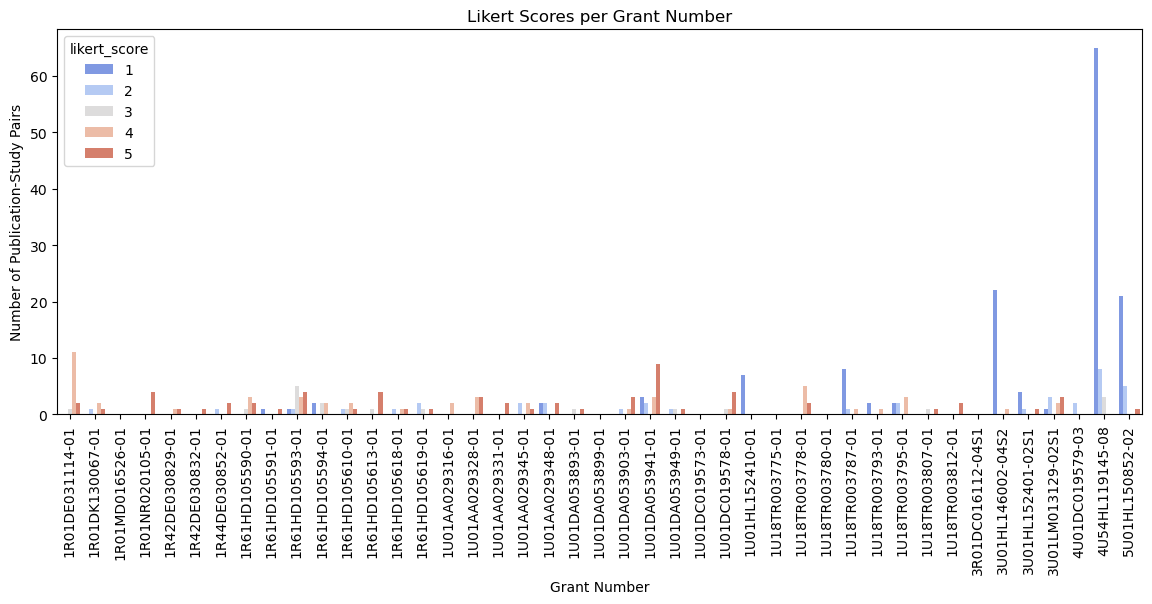

In [25]:
plot_counts(truncated_df, "project_num", "Grant Number")

Outliers (with papers unrelated to RADx-rad objectives) include center grants and/or supplements:
* [4U54HL119145-08](https://reporter.nih.gov/search/f8KFKyeXrUmY3QpNXu5AzQ/project-details/10316833) Boston Biomedical Innovation Center
* [3U01HL146002-04S2](https://reporter.nih.gov/search/Fv3sDGTrfEitv6qBjdFhrw/project-details/10691588) Rapid saliva antigen test for SARS-CoV-2 detection
* [5U01HL150852-02](https://reporter.nih.gov/search/92zXQx6StEGLjC9E9X1VaA/project-details/10022340) Rutgers Optimizes Innovation (ROI) Program
* [1U18TR003787-01](https://reporter.nih.gov/search/LcYG2NDIWUmOOJUjvg_7gg/project-details/10266377) A Handheld Microchip for GC analysis of breath to screen for COVID-19
* [3U01HL152401-02S1](https://reporter.nih.gov/search/4kBUfahtg0m0kSMz0VWJjQ/project-details/10228328) Washington Entrepreneurial Research Evaluation and Commercialization Hub

### Likert Score Distribution by Subproject

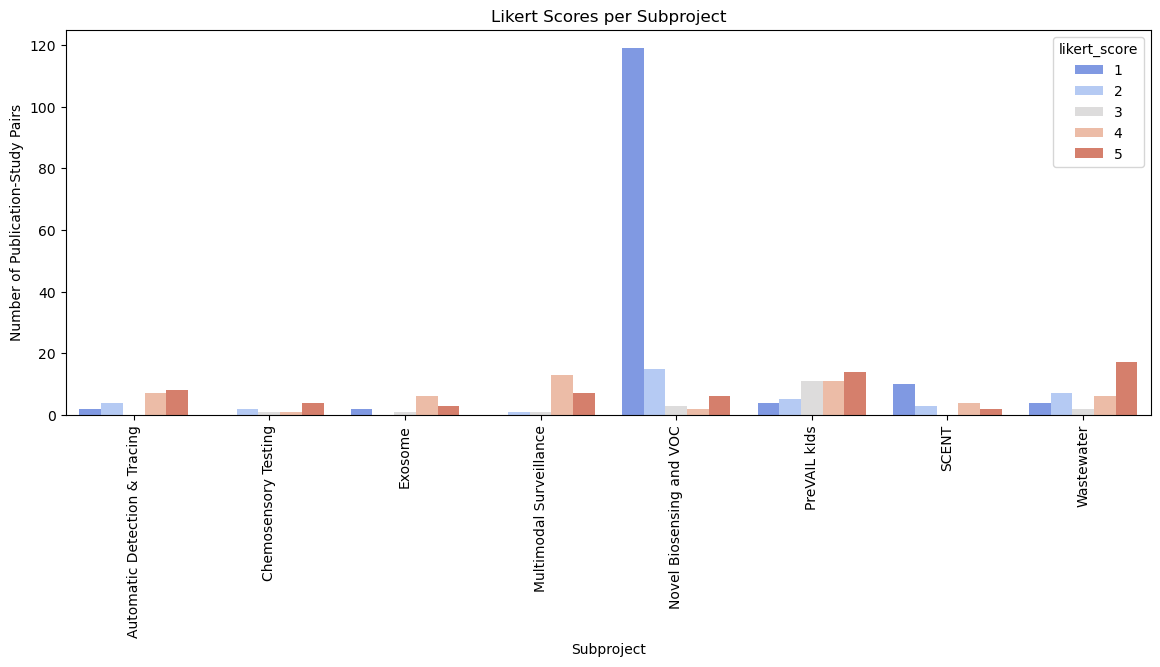

In [26]:
plot_counts(truncated_df, "sub_project", "Subproject")

## 3. Validation of Likert Scoring Method

### Create a Validation Set

#### True Positives
Publications explicitly mentioning both the term "RADx" and the corresponding grant number within the full text are classified as true positives.

In [27]:
radx_mention = pd.read_csv(RADX_RAD_MENTION, dtype=str, keep_default_na=False)
radx_mention["doi"] = "doi:" + radx_mention["doi"]

In [28]:
true_positives = grouped_df.copy()
true_positives = true_positives[true_positives["pm_id"].isin(radx_mention["pm_id"]) |
                                true_positives["doi"].isin(radx_mention["doi"])]

true_positives["actual"] = True
true_positives["predicted"] = true_positives["likert_score"] >= THRESHOLD
n_positives = true_positives.shape[0]

In [29]:
true_positives

,identifier,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,article_type,...,explanation_DeepSeek-R1-Distill-Qwen-32B,explanation_Llama-3.3-70B-Instruct,prompt_tokens_DeepSeek-R1-Distill-Qwen-32B,prompt_tokens_Llama-3.3-70B-Instruct,DeepSeek-R1-Distill-Qwen-32B,Llama-3.3-70B-Instruct,likert_score,selected,actual,predicted
485,36832064_phs002573.v1.p1,36832064,PMC9954708,doi:10.3390/bios13020298,Review of HIV Self Testing Technologies and Pr...,The ability to self-test for HIV is vital to p...,COVID-19|HIV Infections|HIV self-testing|HIV v...,"Bacon, Amanda|Wang, Weijing|Lee, Hankeun|Umrao...",Biosensors,Journal Article|Review,...,The publication abstract discusses HIV self-te...,The publication abstract is not directly relat...,11534,11256,2,2,2.000,False,True,False
585,37851606_phs002602.v1.p1,37851606,PMC10584126,doi:10.1371/journal.pone.0286988,A spatially uniform illumination source for wi...,Illumination uniformity is a critical paramete...,Lighting|Microscopy|Optical Devices,"Çelebi, İris|Aslan, Mete|Ünlü, M Selim",PloS one,Journal Article,...,The publication abstract describes an illumina...,The publication abstract does not directly add...,16827,16413,2,2,2.000,False,True,False
747,40390292_phs002631.v1.p1,40390292,PMC12163592,doi:10.1093/chemse/bjaf015,"Towards universal chemosensory testing: needs,...",Millions of people in the United States experi...,Humans|Olfaction Disorders|Smell|Taste Disorde...,"Munger, Steven D|Zhao, Kai|Barlow, Linda A|Boa...",Chemical senses,Journal Article|Review,...,The publication discusses the barriers and opp...,The publication abstract is related to the fun...,12328,11966,3,4,3.500,True,True,True
748,40390292_phs002699.v1.p1,40390292,PMC12163592,doi:10.1093/chemse/bjaf015,"Towards universal chemosensory testing: needs,...",Millions of people in the United States experi...,Humans|Olfaction Disorders|Smell|Taste Disorde...,"Munger, Steven D|Zhao, Kai|Barlow, Linda A|Boa...",Chemical senses,Journal Article|Review,...,The publication discusses the need for univers...,The publication abstract is related to the res...,12184,11819,3,4,3.500,True,True,True
349,35532905_phs002565.v1.p1,35532905,PMC9112978,doi:10.1021/acs.analchem.2c00554,Aptamer Sandwich Lateral Flow Assay (AptaFlow)...,The COVID-19 pandemic is among the greatest he...,"Antibodies, Viral|Aptamers, Nucleotide|COVID-1...","Yang, Lucy F|Kacherovsky, Nataly|Panpradist, N...",Analytical chemistry,"Journal Article|Research Support, N.I.H., Extr...",...,The publication describes the development of a...,The publication abstract is related to the res...,11540,11258,4,4,4.000,True,True,True
446,36354449_phs002546.v1.p1,36354449,PMC9688365,doi:10.3390/bios12110938,An Experimental Framework for Developing Point...,Biolayer interferometry (BLI) is a well-establ...,Biosensing Techniques|COVID-19|Dielectric Spec...,"Ullah, Sadia Fida|Moreira, Geisianny|Datta, Sh...",Biosensors,Journal Article|Meta-Analysis,...,The publication abstract describes the develop...,The publication abstract is related to the res...,11920,11641,4,4,4.000,True,True,True
706,39749891_phs002542.v1.p1,39749891,PMC11699548,doi:10.1177/00333549241302621,Bringing Pandemic Science to the Classroom: Bu...,"In response to the COVID-19 pandemic, a multid...",COVID-19 education|public health capacity|rura...,"Alameh, Sahar|Hoover, Anna G|Keck, James W|Ber...","Public health reports (Washington, D.C. : 1974)",Journal Article,...,The publication abstract describes an educatio...,The publication abstract is related to the res...,12007,11750,4,4,4.000,True,True,True
751,_phs002570.v1.p1,,,doi:10.1021/acs.jpcc.2c06434,Understanding Oligonucleotide Hybridization an...,"""Semiconducting single-walled carbon nanotubes...",|Carbon nanotubes|Genetics|Hybridization|Quant...,Cui J|Gong X|Cho S-Y|Jin X|Yang S|Khosravi-Far...,J Phys Chem C,Journal Article,...,The publication abstract discusses the develop...,The publication abstract is related to the res...,16978,16557,4,4,4.000,True

#### True Negatives  
Publications released before the COVID-19 pandemic and the initiation of the RADx program (prior to 2020) are classified as **true negatives**, as they clearly cannot be related to RADx-rad objectives.

In [30]:
true_negatives = grouped_df.copy()
true_negatives = true_negatives[true_negatives["year"]< "2020"]

# Shuffle the DataFrame
true_negatives = true_negatives.sample(frac=1, random_state=13).reset_index(drop=True)

# Remove duplicate publications (this happens because a single grant can support multiple studies)
true_negatives.drop_duplicates(subset="pm_id", inplace=True)

# Randomly sample rows from the true_negatives to match the number of true_positives
true_negatives = true_negatives.sample(n=n_positives, random_state=13)
true_negatives["actual"] = False
true_negatives["predicted"] = true_negatives["likert_score"] >= THRESHOLD
true_negatives

,identifier,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,article_type,...,explanation_DeepSeek-R1-Distill-Qwen-32B,explanation_Llama-3.3-70B-Instruct,prompt_tokens_DeepSeek-R1-Distill-Qwen-32B,prompt_tokens_Llama-3.3-70B-Instruct,DeepSeek-R1-Distill-Qwen-32B,Llama-3.3-70B-Instruct,likert_score,selected,actual,predicted
40,29952026_phs002602.v1.p1,29952026,,doi:10.1002/chem.201802054,Injectable Oxygen: Interfacing Materials Chemi...,Intravascular oxygen delivery holds great pote...,blood substitutes|cardiac arrest|intravascular...,"Peng, Yifeng|Kheir, John N|Polizzotti, Brian D","Chemistry (Weinheim an der Bergstrasse, Germany)",Journal Article,...,The publication abstract discusses the develop...,The publication abstract does not directly add...,16775,16362,1,2,1.500,False,False,False
18,30204438_phs002561.v1.p1,30204438,PMC6442678,doi:10.1021/acs.jmedchem.8b00964,Manganese-Based Contrast Agents for Magnetic R...,Gd-based MRI contrast agents (GBCAs) have come...,Animals|Chelating Agents|Contrast Media|Humans...,"Wang, Junfeng|Wang, Huan|Ramsay, Ian A|Erstad,...",Journal of medicinal chemistry,Evaluation Study|Journal Article|Research Supp...,...,The publication abstract focuses on manganese-...,The publication abstract is not related to the...,16999,16580,1,1,1.000,False,False,False
25,26506125_phs002602.v1.p1,26506125,PMC4674364,doi:10.1016/j.bbadis.2015.10.019,S-adenosylhomocysteine induces inflammation th...,S-adenosylhomocysteine (SAH) can induce endoth...,Adhesion molecules|Cell Line|EZH2|Endothelial ...,"Barroso, Madalena|Kao, Derrick|Blom, Henk J|Ta...",Biochimica et biophysica acta,"Journal Article|Research Support, N.I.H., Extr...",...,The publication abstract discusses the role of...,The publication abstract is unrelated to the r...,16964,16550,1,1,1.000,False,False,False
43,27861257_phs002561.v1.p1,27861257,PMC5432394,doi:10.1097/SHK.0000000000000797,Pulmonary Phototherapy to Treat Carbon Monoxid...,Carbon monoxide (CO) poisoning is a common cau...,Androstanols|Animals|Blood Pressure|Body Tempe...,"Zazzeron, Luca|Liu, Chen|Franco, Walfre|Nakaga...","Shock (Augusta, Ga.)",Journal Article,...,The publication abstract discusses the use of ...,The publication abstract is not related to the...,17111,16690,1,1,1.000,False,False,False
15,29997301_phs002602.v1.p1,29997301,PMC6124517,doi:10.1172/jci.insight.121133,Antibody-modified conduits for highly selectiv...,Cytokines play an important role in dysregulat...,Anesthesiology|Animals|Antibodies|Cytokines|Hu...,"McAlvin, J Brian|Wylie, Ryan G|Ramchander, Kri...",JCI insight,"Journal Article|Research Support, N.I.H., Extr...",...,The publication abstract focuses on antibody-m...,The publication abstract is not directly relat...,16855,16442,1,2,1.500,False,False,False
59,27729363_phs002602.v1.p1,27729363,PMC5079441,doi:10.1161/CIRCIMAGING.116.005091,A Magnetic Resonance Imaging-Conditional Exter...,Subjects undergoing cardiac arrest within a ma...,"Animals|Defibrillators|Disease Models, Animal|...","Schmidt, Ehud J|Watkins, Ronald D|Zviman, Mene...",Circulation. Cardiovascular imaging,Journal Article,...,The publication abstract describes the develop...,The publication abstract is unrelated to the r...,17008,16595,1,1,1.000,False,False,False
32,26149051_phs002561.v1.p1,26149051,PMC5565795,doi:10.1111/jth.12942,Road blocks in making platelets for transfusion.,The production of laboratory-generated human p...,Bioreactors|Blood Platelets|Cell Culture Techn...,"Thon, J N|Medvetz, D A|Karlsson, S M|Italiano,...",Journal of thrombosis and haemostasis : JTH,"Journal Article|Research Support, N.I.H., Extr...",...,The publication abstract discusses challenges ...,The publication abstract is unrelated to the r...,16823,16405,1,1,1.000,False,False,False
14,30350585_phs002602.v1.p1,30350585,PMC6516866,doi:10.1021/acs.chemrev.8b00363,Chemistry of MRI Contrast Agents: Current Chal...,Tens of millions of contrast-enhanced magnetic...,Abdomen|Brain|Central Nervous System|Chelating

In [31]:
test_set = pd.concat([true_negatives, true_positives], ignore_index=True)
test_set.sort_values(by="actual", inplace=True)

### Evaluate Binary Classification

#### Evaluate the Binary Classification with an ROC Curve

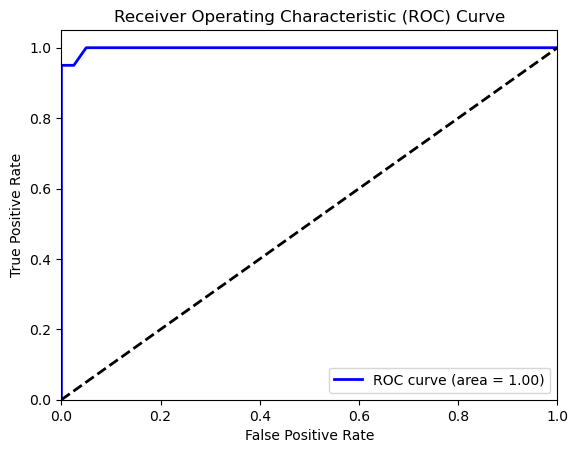

In [32]:
# Extract the "likert_score" and "actual" columns
likert_score = test_set["likert_score"]
actual = test_set["actual"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(actual, likert_score)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

#### Binary classification metrics

In [33]:
accuracy = accuracy_score(test_set["actual"], test_set["predicted"])
precision = precision_score(test_set["actual"], test_set["predicted"])
recall = recall_score(test_set["actual"], test_set["predicted"])  # Sensitivity
f1 = f1_score(test_set["actual"], test_set["predicted"])
conf_matrix = confusion_matrix(test_set["actual"], test_set["predicted"])

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Compute specificity
specificity = tn / (tn + fp)

# Compute Positive Predictive Value (PPV) - Same as Precision
ppv = tp / (tp + fp)

# Compute Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# Display results
classification_metrics = {
    "Method": [ANNOTATION],
    "Accuracy": [accuracy],
    "F1 Score": [f1],
    "Precision": [precision],
    "Recall": [recall],
    "Specificity": [specificity],
    "Sensitivity": [recall],
    "Positive Predictive Value (PPV)": [ppv],
    "Negative Predictive Value (NPV)": [npv],
    "AUC": [roc_auc],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn],
    "TP": [tp],
}

# Convert metrics to DataFrame for display
metrics_df = pd.DataFrame.from_dict(classification_metrics)
metrics_df = metrics_df.transpose().reset_index()
metrics_df.columns = ["metric", "value"]
metrics_df

,metric,value
0,Method,annotation_full_text_5
1,Accuracy,0.975
2,F1 Score,0.974
3,Precision,1.000
4,Recall,0.950
5,Specificity,1.000
6,Sensitivity,0.950
7,Positive Predictive Value (PPV),1.000
8,Negative Predictive Value (NPV),0.952
9,AUC,0.998


#### Confusion Matrix

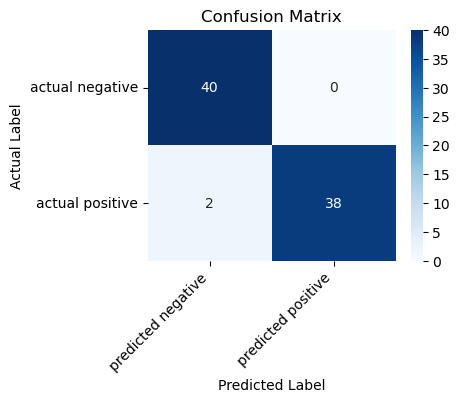

In [34]:
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["predicted negative", "predicted positive"], 
            yticklabels=["actual negative", "actual positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha="right")  # Rotate labels and align them to the right
plt.yticks(rotation=0, ha="right") 
plt.show()

In [35]:
misclassified = test_set[test_set["actual"] != test_set["predicted"]]
misclassified

,identifier,pm_id,pmc_id,doi,title,abstract,keywords,authors,journal,article_type,...,explanation_DeepSeek-R1-Distill-Qwen-32B,explanation_Llama-3.3-70B-Instruct,prompt_tokens_DeepSeek-R1-Distill-Qwen-32B,prompt_tokens_Llama-3.3-70B-Instruct,DeepSeek-R1-Distill-Qwen-32B,Llama-3.3-70B-Instruct,likert_score,selected,actual,predicted
40,36832064_phs002573.v1.p1,36832064,PMC9954708,doi:10.3390/bios13020298,Review of HIV Self Testing Technologies and Pr...,The ability to self-test for HIV is vital to p...,COVID-19|HIV Infections|HIV self-testing|HIV v...,"Bacon, Amanda|Wang, Weijing|Lee, Hankeun|Umrao...",Biosensors,Journal Article|Review,...,The publication abstract discusses HIV self-te...,The publication abstract is not directly relat...,11534,11256,2,2,2.000,False,True,False
41,37851606_phs002602.v1.p1,37851606,PMC10584126,doi:10.1371/journal.pone.0286988,A spatially uniform illumination source for wi...,Illumination uniformity is a critical paramete...,Lighting|Microscopy|Optical Devices,"Çelebi, İris|Aslan, Mete|Ünlü, M Selim",PloS one,Journal Article,...,The publication abstract describes an illumina...,The publication abstract does not directly add...,16827,16413,2,2,2.000,False,True,False


The two false negative publications mention the RADx-rad program. However, they don't match the primary program objectives and should be considered negatives.